# Part 2: Naive Bayes Model

In [45]:
%pylab inline
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

plt.rcParams['figure.dpi']= 150
sns.set(style="whitegrid")

Populating the interactive namespace from numpy and matplotlib


## Split data into training set and test set
In order to compare the performance of different models, we need to split the training set into training set and test set, we only use training set to train our model and then test on test set.

In [41]:
# Read raw training data
data = pd.read_csv("train.csv")

# It is better to choose random_state=42
# split training data into training set and test set with ratio 8:2
train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print("train.shape: ", train.shape)
print("test.shape: ", test.shape)

X_train = train.comment_text
X_test = test.comment_text

train.shape:  (127656, 8)
test.shape:  (31915, 8)


## Visualise the number of comments in each category in training set and test set:

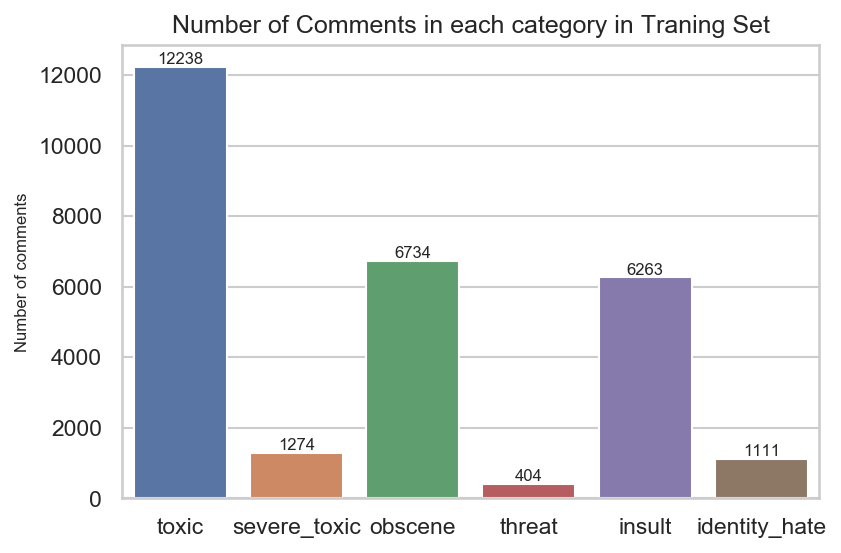

In [42]:

plt.rcParams['figure.dpi']= 150
toxic_comment_counts = [train[category].sum() for category in categories]
toxic_comment_counts = pd.DataFrame(np.array(toxic_comment_counts).reshape(1, 6), columns=categories)
toxic_comment_counts
ax = sns.barplot(data=toxic_comment_counts)
pats = ax.patches
plt.title("Number of Comments in each category in Traning Set", fontsize=12)
plt.ylabel('Number of comments', fontsize=8)
for pat, value in zip(pats, toxic_comment_counts.values[0]):
    height = pat.get_height()
    ax.text(pat.get_x() + pat.get_width()/2, height + 5, value, ha='center', va='bottom', fontsize=8)
plt.show()

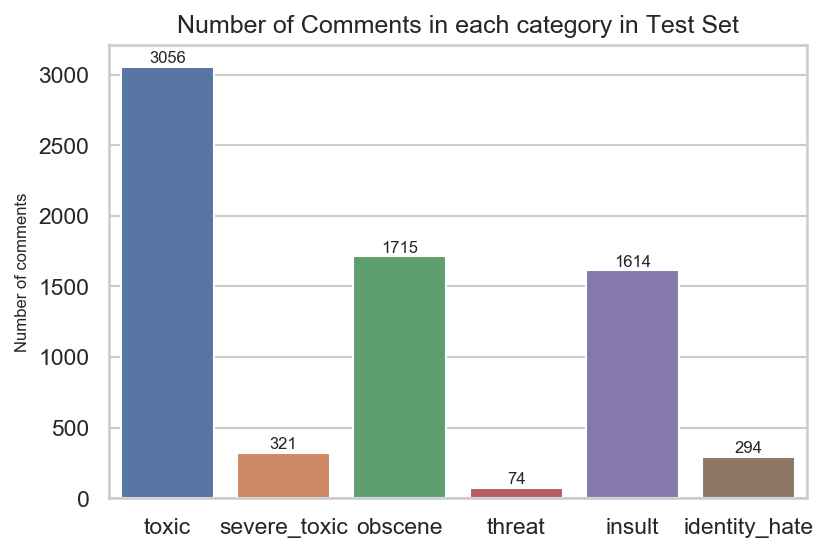

In [43]:
toxic_comment_counts = [test[category].sum() for category in categories]
toxic_comment_counts = pd.DataFrame(np.array(toxic_comment_counts).reshape(1, 6), columns=categories)
toxic_comment_counts
ax = sns.barplot(data=toxic_comment_counts)
pats = ax.patches
plt.title("Number of Comments in each category in Test Set", fontsize=12)
plt.ylabel('Number of comments', fontsize=8)
for pat, value in zip(pats, toxic_comment_counts.values[0]):
    height = pat.get_height()
    ax.text(pat.get_x() + pat.get_width()/2, height + 5, value, ha='center', va='bottom', fontsize=8)
plt.show()

## Build the Naive Bayes baseline model
In order to apply machine learning model to text data, we can use "Bag of words" model to represent the data. Firstly, we need to extract words from the raw text and build a dictionary, then transform the raw "comment_text" records into a very large feacture vector which encoded as all the words in such dictionary. Each index of the vector represents a word and each value of the entry represents the word count in a specific record document. Then each record is represented as a very large vector, however most of the entry is 0, because a record only contains a very few words in the dictionary. So that we can represent such data structure in a "dense" way using sparse matrices in python in order to reduce memory usage.

We observe that the length of each "comment_text" varys a lot, when we apply the "word count vector" to the dataset, longer text will tend to have more counts, which will result in less informative for catpturing the true "meaning" of the document. We can tackle this problem using **term frequency–inverse document frequency** which can be calculated as (there are a few variance):

$$
{\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}
$$
where
$$
{\displaystyle \mathrm {tf} (t,d)=\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}
$$
and
$$
 \mathrm{idf}(t, D) =  \log \frac{N}{|\{d \in D: t \in d\}|}
$$
* $f_{{t,d}}$ is the count of term $t$ in document $d$
* $N$ is the total number of documents in the dataset ${N={|D|}}$

Intuitively, we can interpret tf-idf as the importance of a word in the documents, the higher the value of tf-idf, the more important of the term is.

Since this is a multi-label classification problem, we can use oneVsRest strategy to build a model for each lebel and then perform the prediction using the model which coresponds to each label. In order to see the performance of the baseline model, we can use k fold cross validation to evaluate the model. We first evaluate a Naive Bayes Model which learns class prior probabilities. Then we compare it with a model without learning the class prior.

## First try to vectorise comments using tf-idf method

In [51]:
# initalise naive bayes model with default parameter and use tf-idf vectorizer to vectorize comments
clf = make_pipeline(TfidfVectorizer(stop_words="english"), MultinomialNB())
fold = 10
results = pd.DataFrame()

cross_validation_score_name = ['roc_auc']
for category in categories:
    scores = cross_validate(clf, X_train, train[category], cv=fold, scoring="roc_auc")
    result = pd.DataFrame()
    for scn in cross_validation_score_name:
        result = result.append(pd.DataFrame(np.array([scores["test_score"],[scn]*fold]).T, columns=["value", "score_name"]), ignore_index=True)    
    cate = pd.DataFrame([category]*(len(cross_validation_score_name)*fold), columns=['category'])
    results = results.append(pd.concat([result, cate], axis=1), ignore_index=True)
results.head()

,value,score_name,category
0,0.8792966126553435,roc_auc,toxic
1,0.8720904075255703,roc_auc,toxic
2,0.8895037221265218,roc_auc,toxic
3,0.8850821396253298,roc_auc,toxic
4,0.889251694295231,roc_auc,toxic


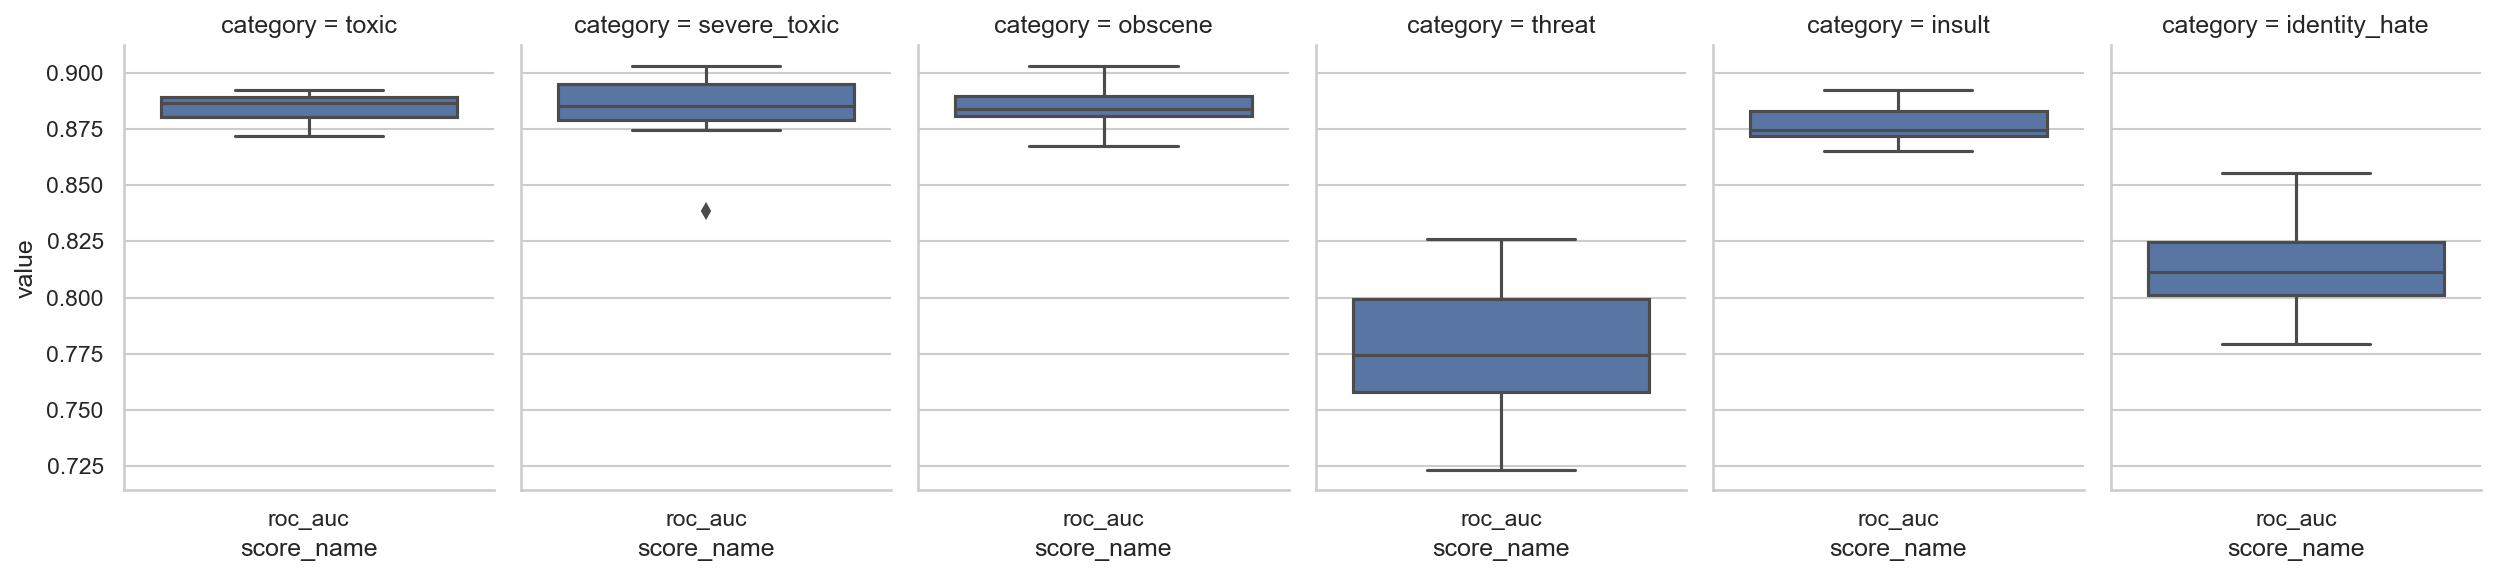

In [52]:
results["value"] = results.value.astype(float)
g = sns.catplot(x="score_name", y="value", col="category", data=results, kind="box", height=4, aspect=.7);

In [65]:
compare1 = pd.concat([results,pd.DataFrame(["tf-idf"]*60, columns=["param"])], axis=1)

## Then try to vectorise data using word counts

In [69]:
# initalise naive bayes model with default parameter and use CountVectorizer to vectorize comments
clf = make_pipeline(CountVectorizer(stop_words="english"), MultinomialNB())
fold = 10
results = pd.DataFrame()

cross_validation_score_name = ['roc_auc']
for category in categories:
    scores = cross_validate(clf, X_train, train[category], cv=fold, scoring="roc_auc")
    result = pd.DataFrame()
    for scn in cross_validation_score_name:
        result = result.append(pd.DataFrame(np.array([scores["test_score"],[scn]*fold]).T, columns=["value", "score_name"]), ignore_index=True)    
    cate = pd.DataFrame([category]*(len(cross_validation_score_name)*fold), columns=['category'])
    results = results.append(pd.concat([result, cate], axis=1), ignore_index=True)
results.head()

,value,score_name,category
0,0.8955310839752062,roc_auc,toxic
1,0.8859032739763728,roc_auc,toxic
2,0.9080148318785723,roc_auc,toxic
3,0.8990104554211218,roc_auc,toxic
4,0.9068362009506628,roc_auc,toxic


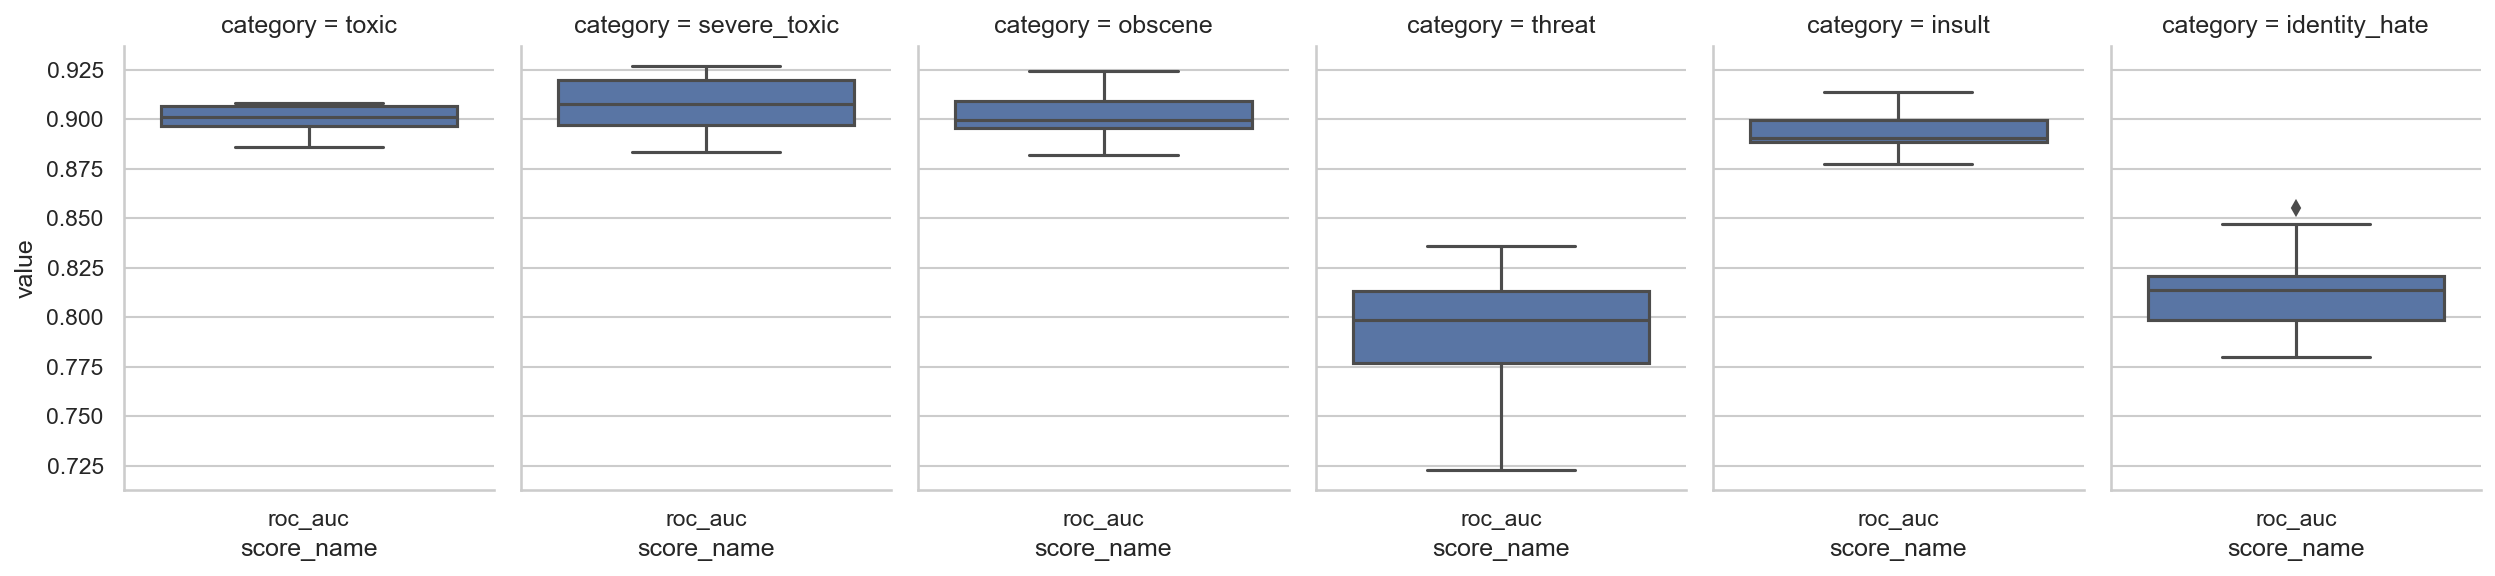

In [70]:
results["value"] = results.value.astype(float)
g = sns.catplot(x="score_name", y="value", col="category", data=results, kind="box", height=4, aspect=.7);

In [74]:
compare2 = pd.concat([results,pd.DataFrame(["wordCount"]*60, columns=["param"])], axis=1)

## Try to test on cleaned data

In [81]:
# Read raw training data
data_cleaned = pd.read_csv("cleaned_train_data.csv")

# It is better to choose random_state=42
train_cleaned, test_cleaned = train_test_split(data_cleaned, test_size=0.2, random_state=42, shuffle=True)
print("train_cleaned.shape: ", train_cleaned.shape)
print("test_cleaned.shape: ", test_cleaned.shape)

X_train_cleaned = train_cleaned.comment_text
X_test_cleaned = test_cleaned.comment_text


train_cleaned.shape:  (127656, 8)
test_cleaned.shape:  (31915, 8)


In [84]:
# initalise naive bayes model with default parameter and use CountVectorizer to vectorize comments
clf = make_pipeline(CountVectorizer(stop_words="english"), MultinomialNB())
fold = 10
results = pd.DataFrame()

cross_validation_score_name = ['roc_auc']
for category in categories:
    scores = cross_validate(clf, X_train_cleaned, train_cleaned[category], cv=fold, scoring="roc_auc")
    result = pd.DataFrame()
    for scn in cross_validation_score_name:
        result = result.append(pd.DataFrame(np.array([scores["test_score"],[scn]*fold]).T, columns=["value", "score_name"]), ignore_index=True)    
    cate = pd.DataFrame([category]*(len(cross_validation_score_name)*fold), columns=['category'])
    results = results.append(pd.concat([result, cate], axis=1), ignore_index=True)
results.head()

,value,score_name,category
0,0.9136261230651794,roc_auc,toxic
1,0.9071495634584914,roc_auc,toxic
2,0.927580275164418,roc_auc,toxic
3,0.9161734056240183,roc_auc,toxic
4,0.9248666492820197,roc_auc,toxic


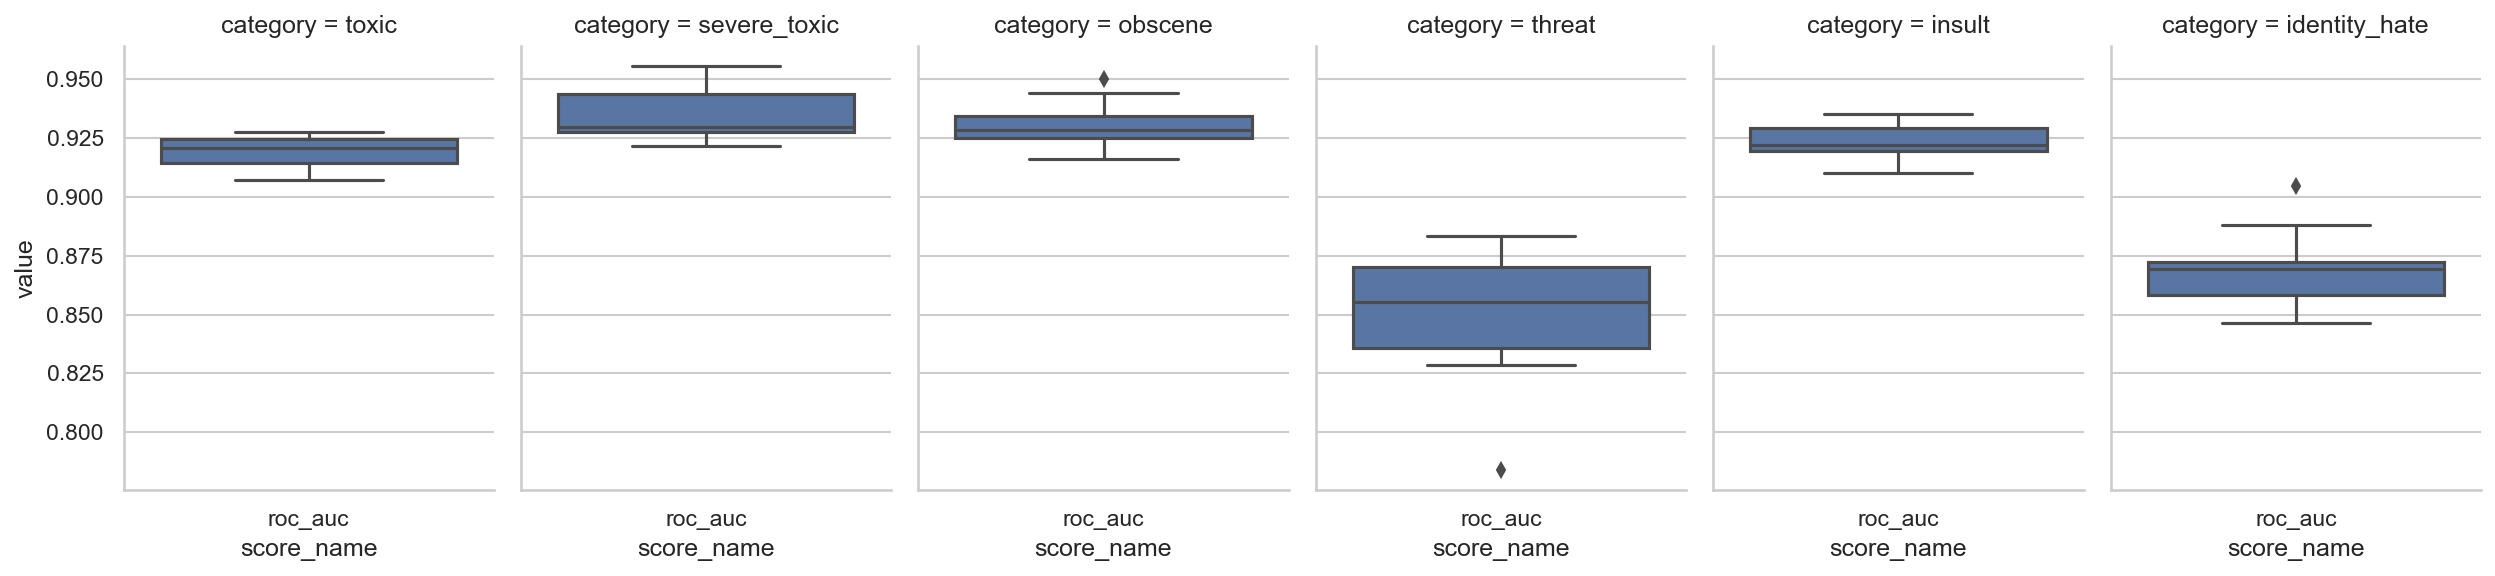

In [85]:
results["value"] = results.value.astype(float)
g = sns.catplot(x="score_name", y="value", col="category", data=results, kind="box", height=4, aspect=.7);

In [86]:
compare3 = pd.concat([results,pd.DataFrame(["cleaned_data"]*60, columns=["param"])], axis=1)

In [88]:
temp = compare1.append(compare2, ignore_index=True)
result = temp.append(compare3, ignore_index=True)

In [97]:
result

,value,score_name,category,param
0,0.879297,roc_auc,toxic,tf-idf
1,0.872090,roc_auc,toxic,tf-idf
2,0.889504,roc_auc,toxic,tf-idf
3,0.885082,roc_auc,toxic,tf-idf
4,0.889252,roc_auc,toxic,tf-idf
5,0.888165,roc_auc,toxic,tf-idf
6,0.883685,roc_auc,toxic,tf-idf
7,0.877321,roc_auc,toxic,tf-idf
8,0.892614,roc_auc,toxic,tf-idf
9,0.890364,roc_auc,toxic,tf-idf


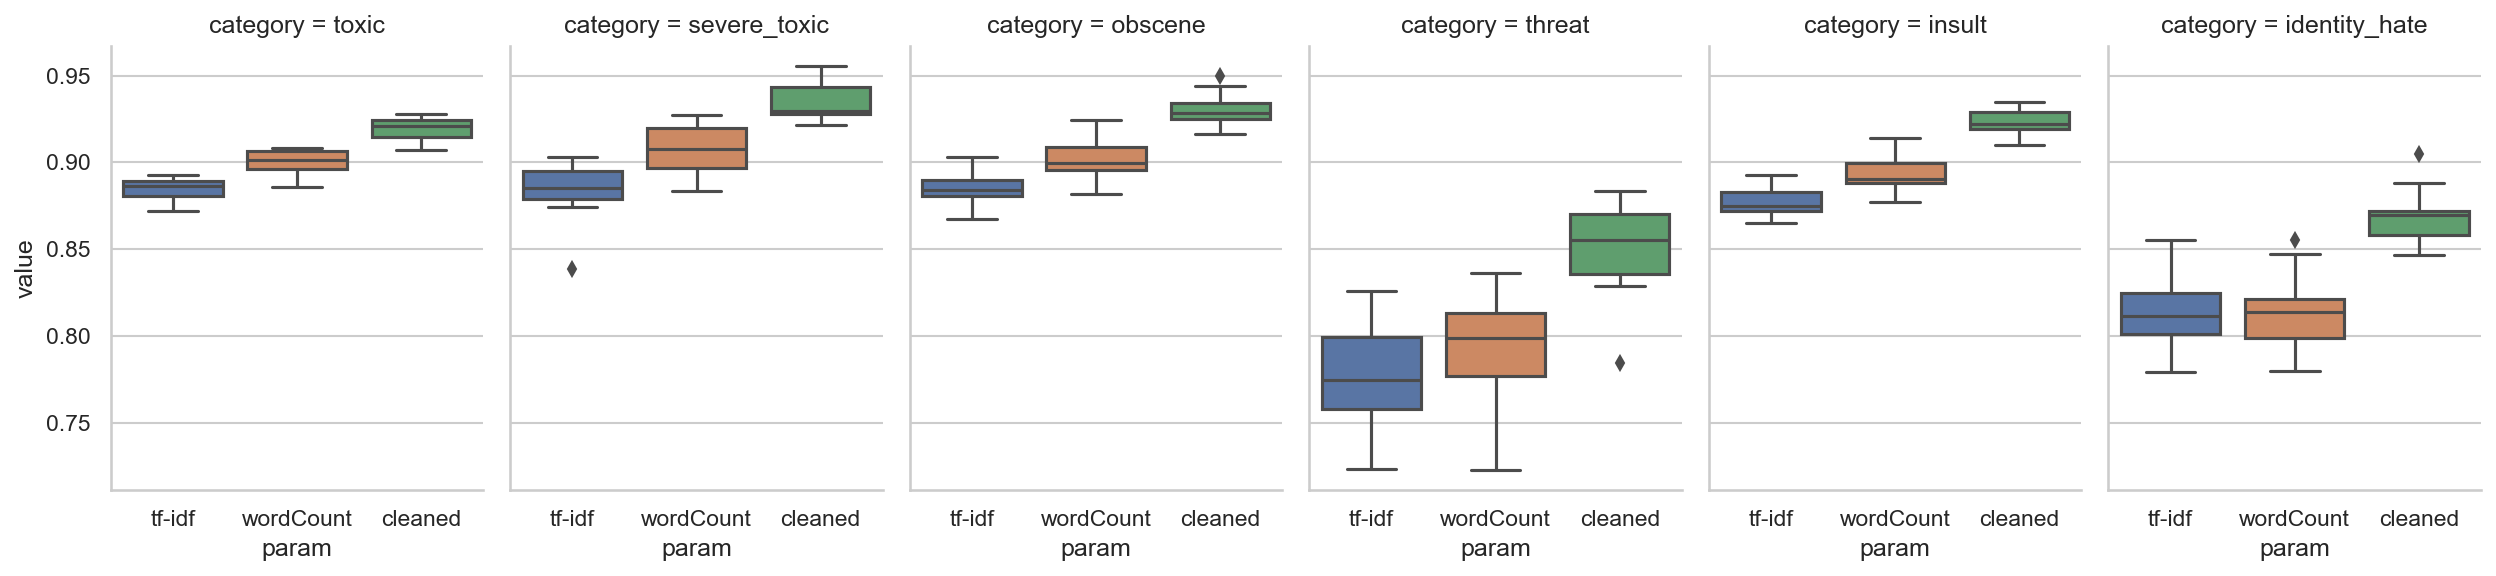

In [98]:
g = sns.catplot(x="param", y="value", col="category", data=result, kind="box", height=4, aspect=.7);

In [99]:
result.to_csv("naive_bayes_compare_param.csv", index=False)

## Apply Naive Bayes model on test set

According to the above results, we can select CountVectorizer to vectorize the training set and then test performance on the test set.

In [152]:
X_train = X_train_cleaned
X_test = X_test_cleaned

# Initialise CountVectorizer and fit all the training data split
count_vect = CountVectorizer(stop_words="english")
X_train_counts = count_vect.fit_transform(X_train)
print('X_train_counts.shape: ', X_train_counts.shape)

testSetX_vec = count_vect.transform(X_test)
print('testSetX_vec.shape: ', testSetX_vec.shape)


X_train_counts.shape:  (127656, 56192)
testSetX_vec.shape:  (31915, 56192)


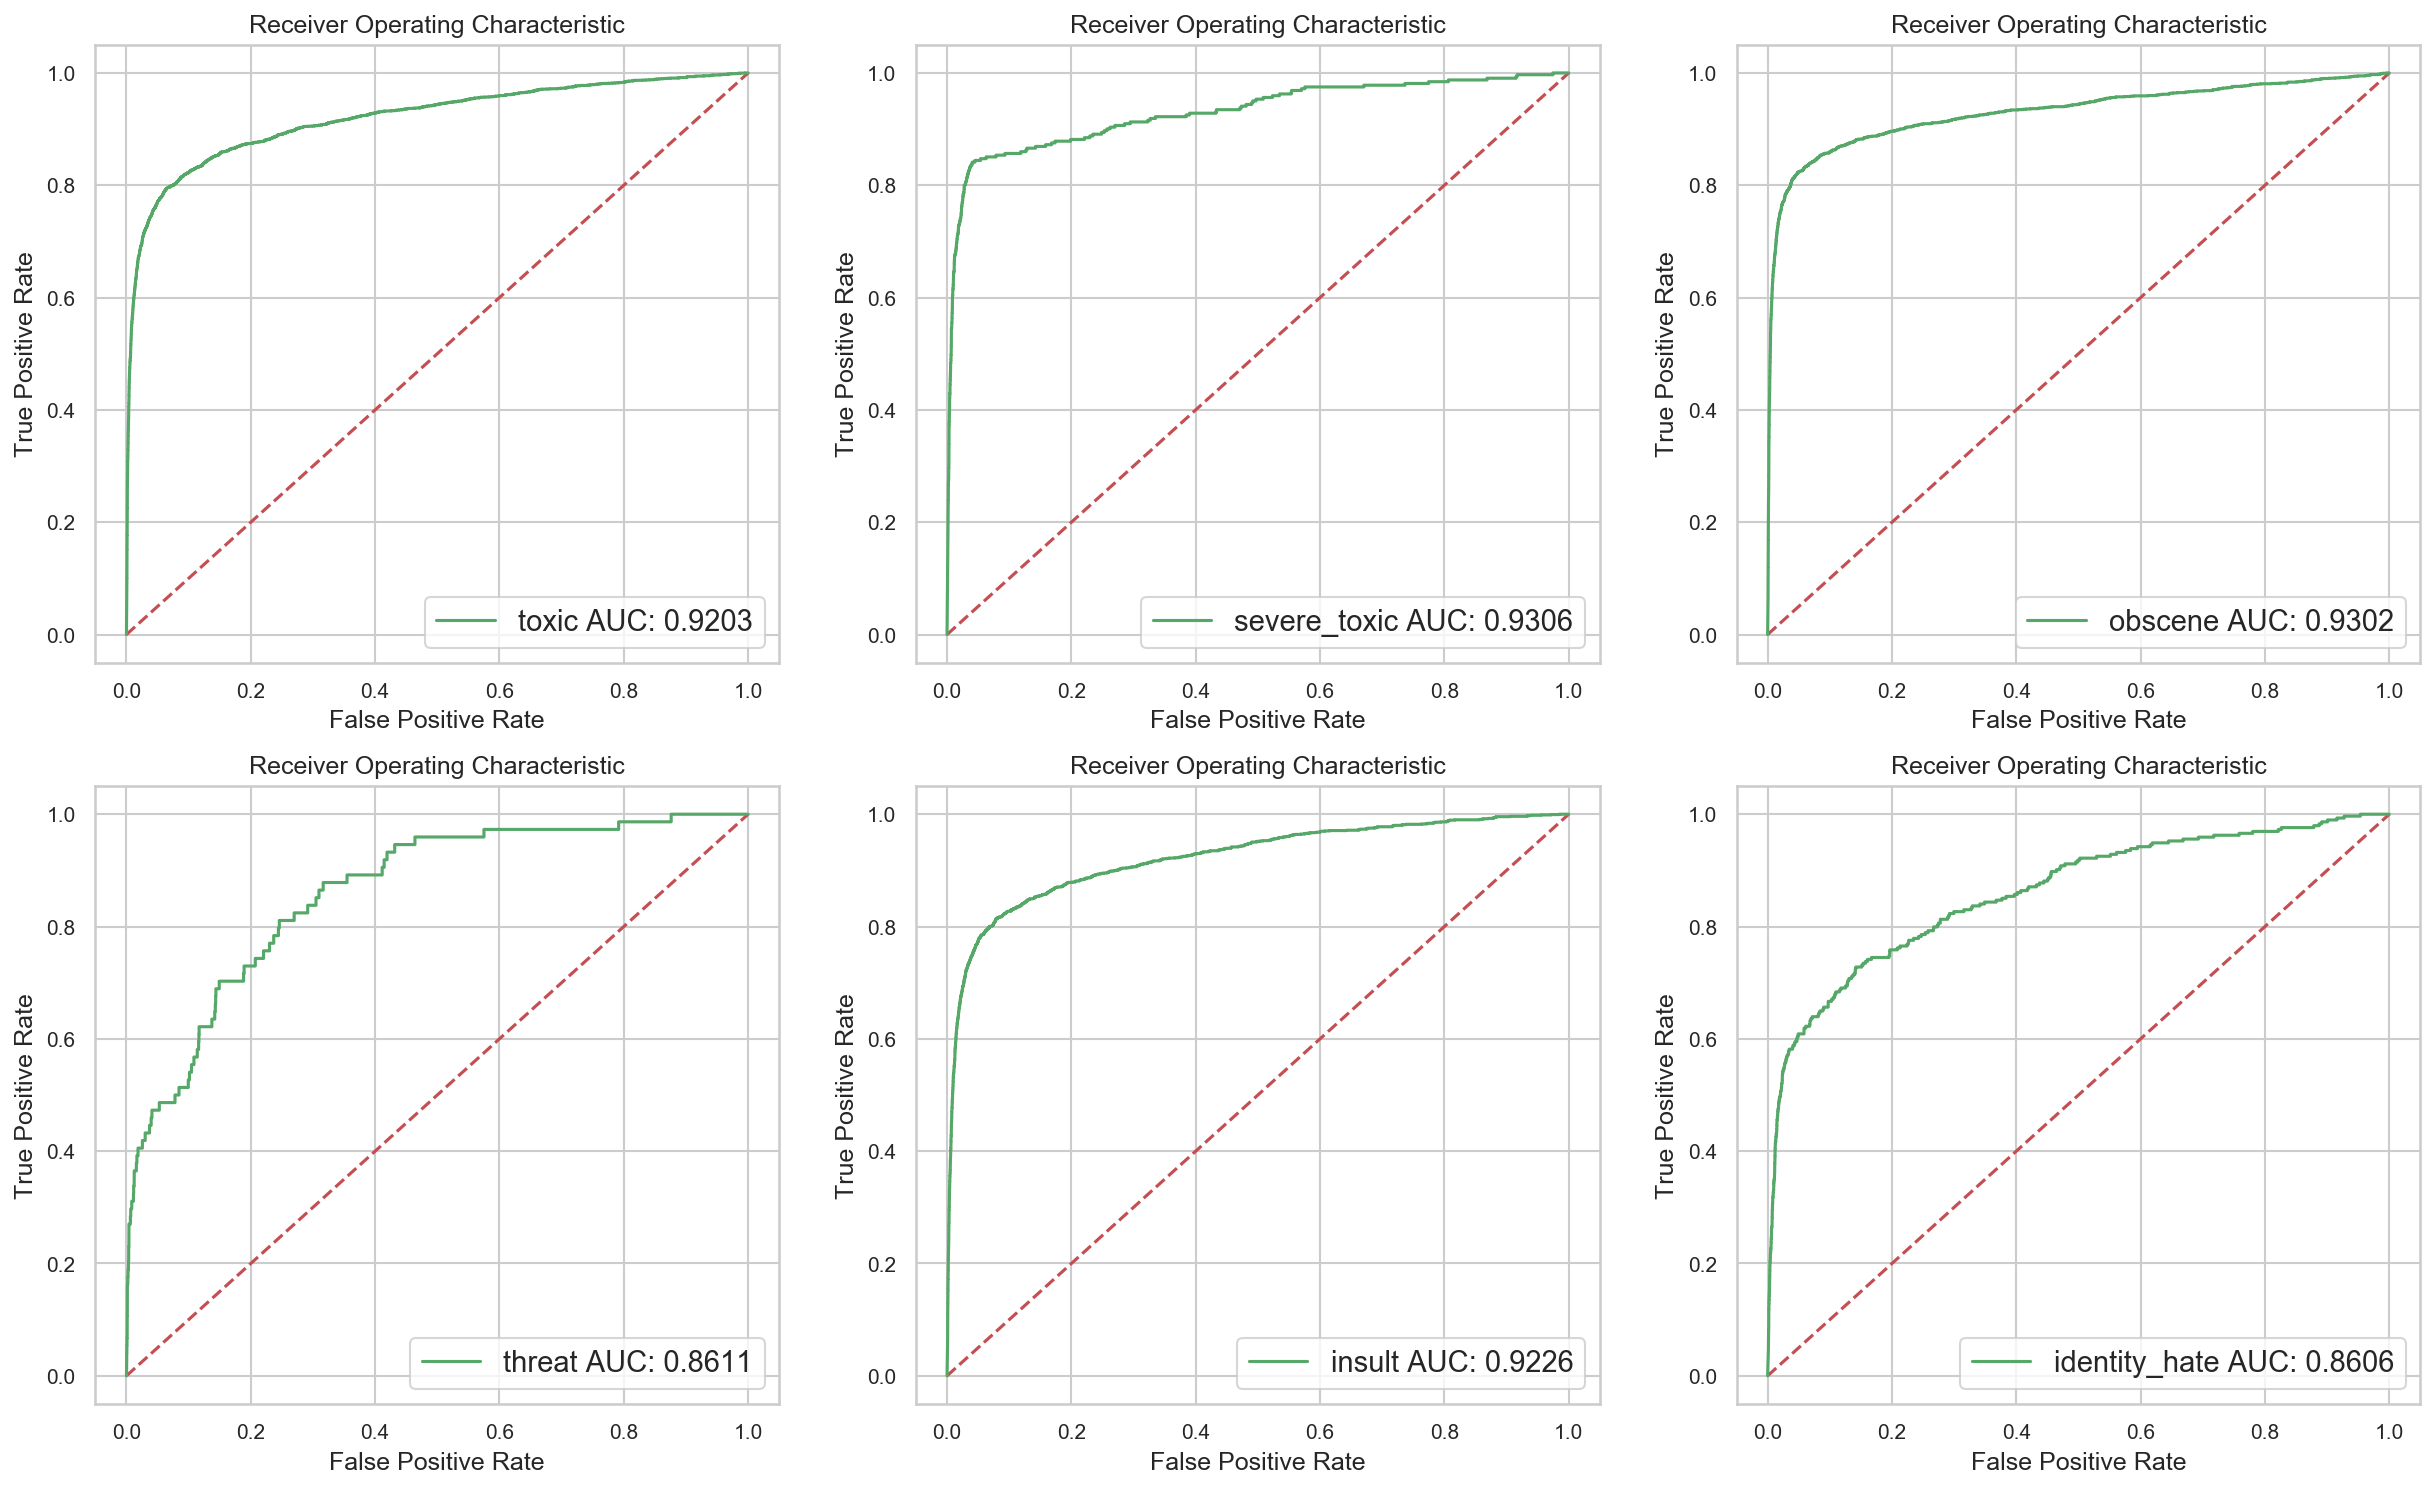

In [145]:
# plot roc curve for each category
fig2, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 12))
for i, ax in enumerate(axes.flatten()):
    # build each model for each category
    clf = MultinomialNB().fit(X_train_counts, train_cleaned[categories[i]])
    predictProbs = clf.predict_proba(testSetX_vec)
    
    # set the positive class to be 1
    predictProbs = predictProbs[:, 1]
    fpr, tpr, thresholds = roc_curve(test_cleaned[categories[i]], predictProbs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    label = '{} AUC: {:.4f}'.format(categories[i], roc_auc)
    ax.plot([0,1], [0,1], 'r--')
    ax.plot(fpr, tpr, c = 'g', label = label)
    ax.set_title('Receiver Operating Characteristic', fontsize = 12)
    ax.set_xlabel('False Positive Rate', fontsize = 12)
    ax.set_ylabel('True Positive Rate', fontsize = 12)
    ax.legend(loc = 'lower right', fontsize = 14)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)

    

## Apply Naive Bayes on Kaggle Test Data Set

In [146]:
testData = pd.read_csv("cleaned_test_data.csv")
testLabel = pd.read_csv("test_labels.csv")
testDataMerge = pd.merge(left=testData,right=testLabel, left_on='id', right_on='id')
testDataMerge[categories] = testDataMerge[categories]

# drop rows if any column contains -1
selectValidRow = testDataMerge[categories].eq(-1).all(axis=1)
kaggle_test = testDataMerge.mask(selectValidRow).dropna(axis=0)
kaggle_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank you for understanding i think very highl...,0.0,0.0,0.0,0.0,0.0,0.0
7,000247e83dcc1211,dear god this site is horrible,0.0,0.0,0.0,0.0,0.0,0.0
11,0002f87b16116a7f,somebody will invariably try to add religion r...,0.0,0.0,0.0,0.0,0.0,0.0
13,0003e1cccfd5a40a,it says it right there that it is a type the t...,0.0,0.0,0.0,0.0,0.0,0.0
14,00059ace3e3e9a53,before adding a new product to the list make s...,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
kaggle_test.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [153]:
X_train_all = data_cleaned.comment_text
X_test_kaggle = kaggle_test.comment_text

# Initialise CountVectorizer and fit all the training data
count_vect = CountVectorizer(stop_words="english")
X_train_all_vec = count_vect.fit_transform(X_train_all)
print('X_train_all_vec.shape: ', X_train_all_vec.shape)

X_test_kaggle_vec = count_vect.transform(X_test_kaggle)
print('X_test_kaggle_vec.shape: ', X_test_kaggle_vec.shape)

X_train_all_vec.shape:  (159571, 59188)
X_test_kaggle_vec.shape:  (63959, 59188)


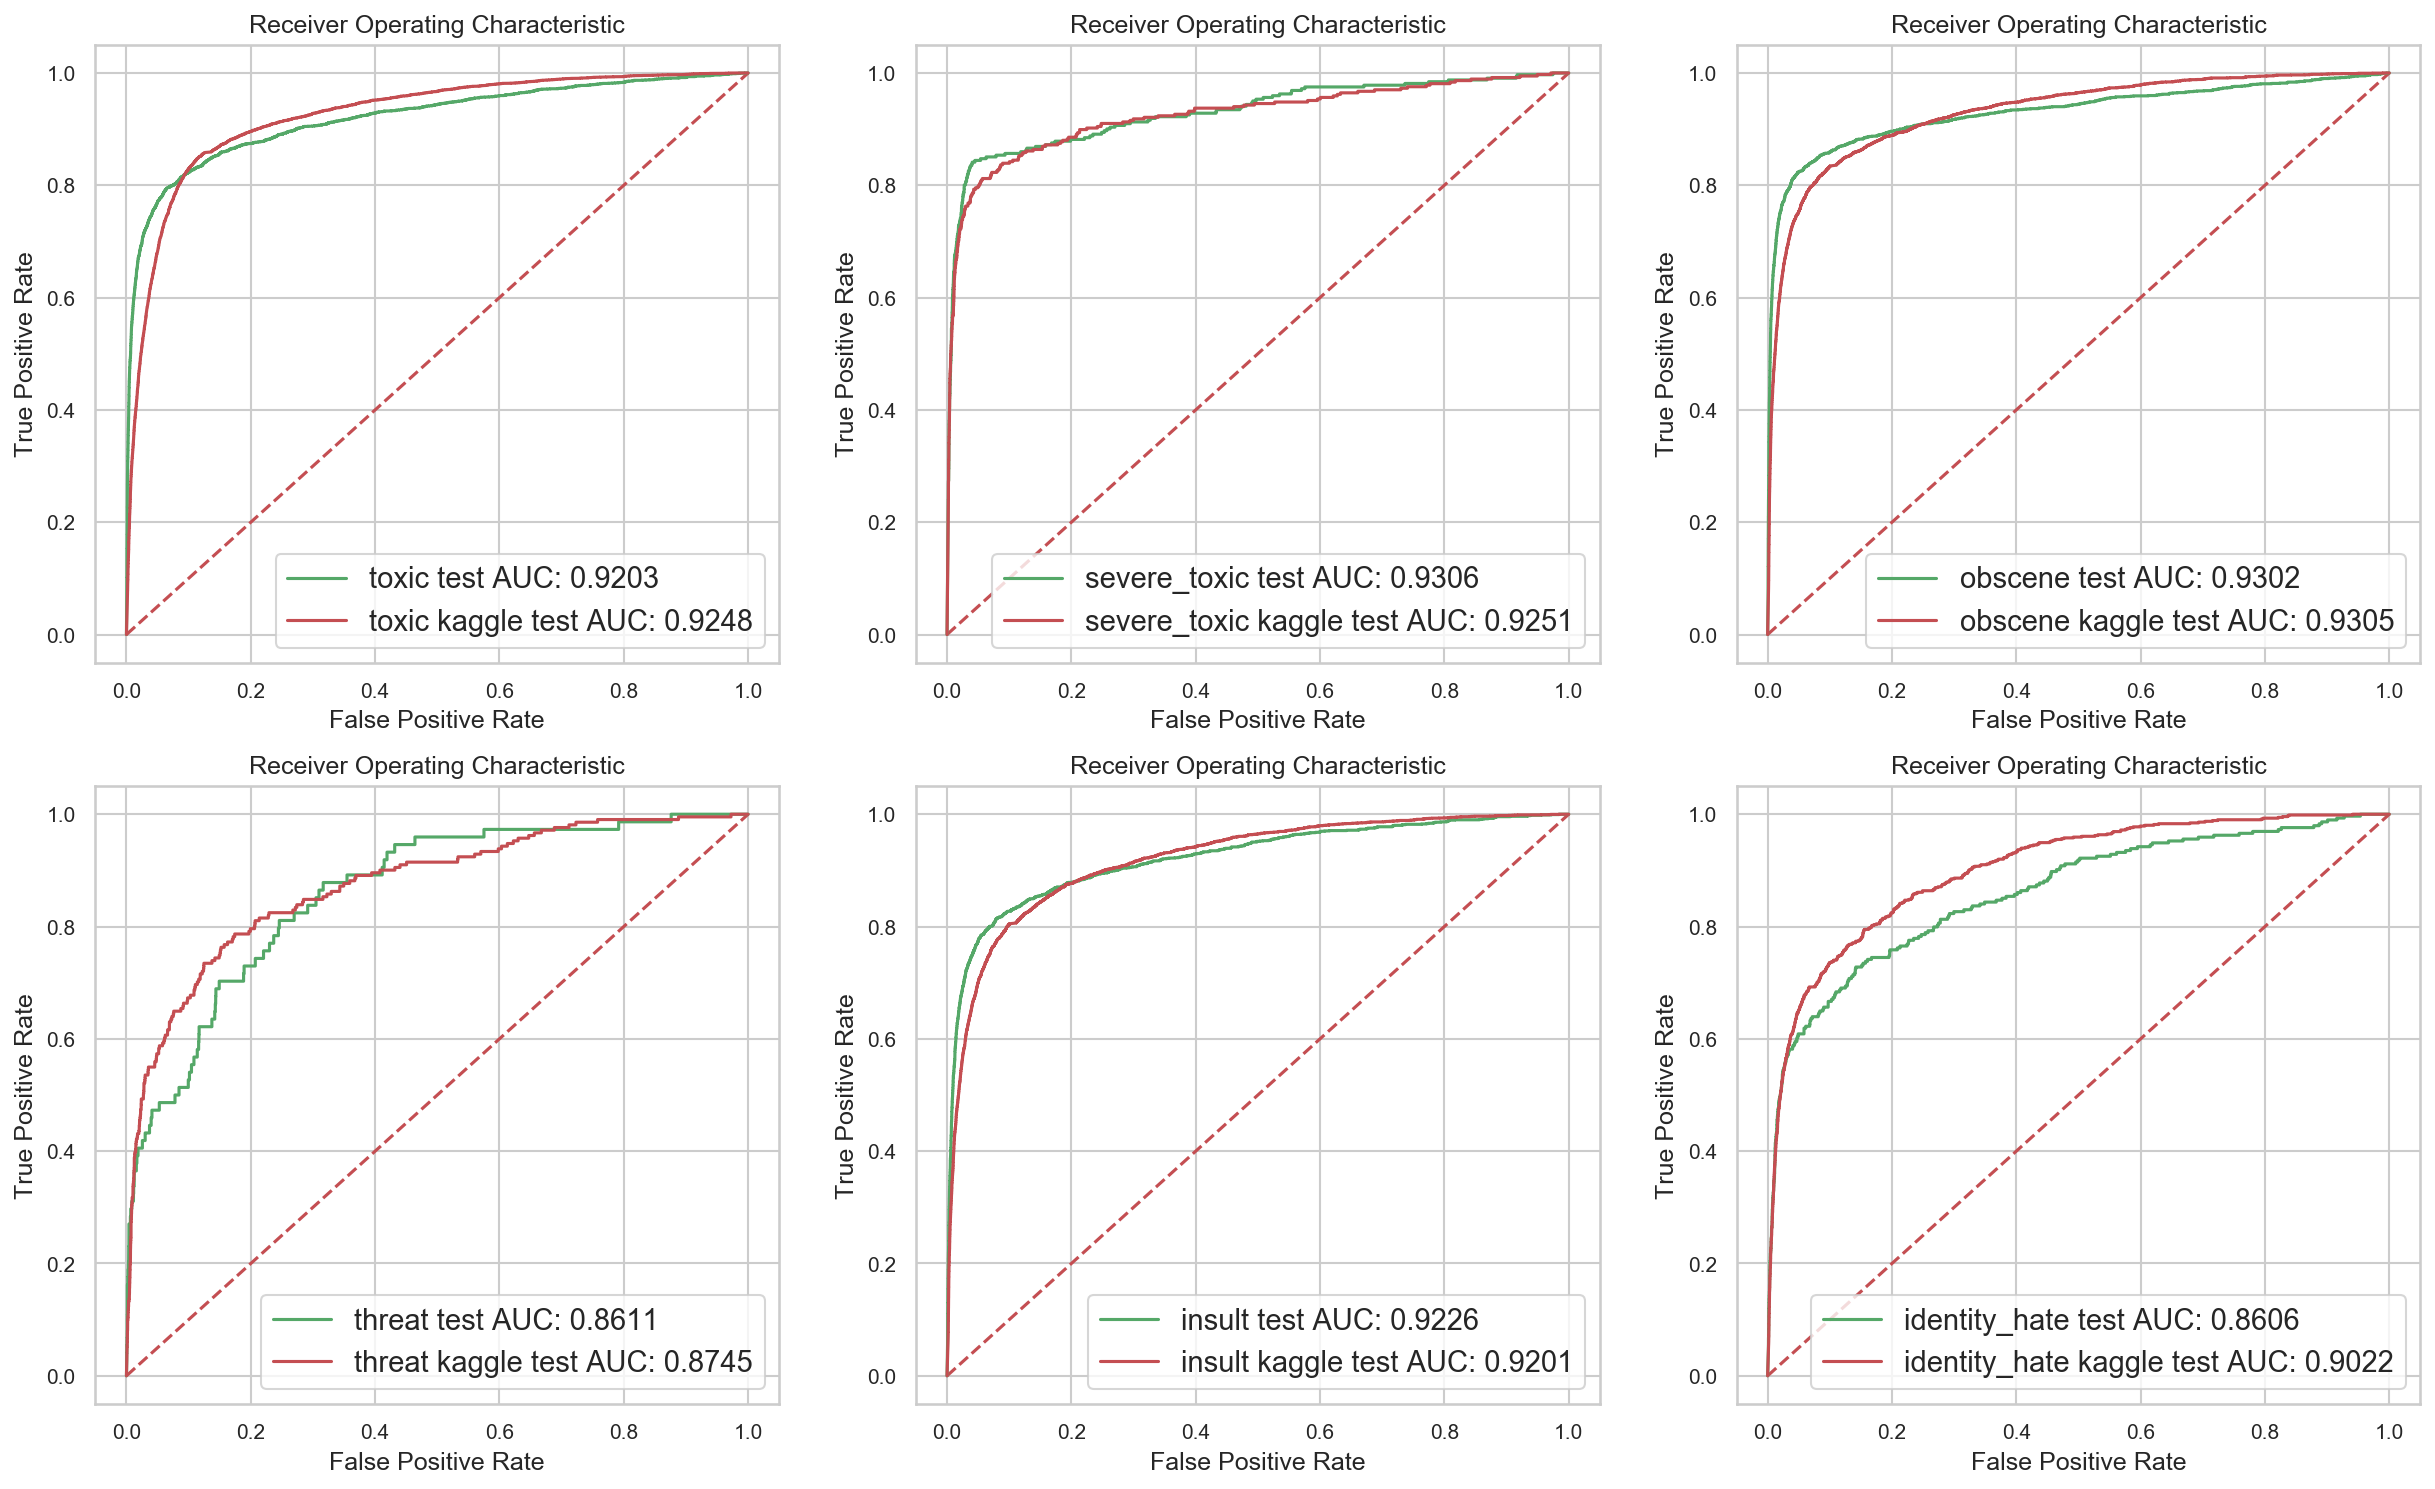

In [151]:
# plot roc curve for each category
fig2, axes = plt.subplots(nrows=2, ncols=3, figsize = (20, 12))
for i, ax in enumerate(axes.flatten()):
    # build model for split test set
    clf = MultinomialNB().fit(X_train_counts, train_cleaned[categories[i]])
    predictProbs = clf.predict_proba(testSetX_vec)
    predictProbs = predictProbs[:, 1]
    fpr, tpr, thresholds = roc_curve(test_cleaned[categories[i]], predictProbs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    label = '{} test AUC: {:.4f}'.format(categories[i], roc_auc)
    ax.plot([0,1], [0,1], 'r--')
    ax.plot(fpr, tpr, c = 'g', label = label)
    ax.set_title('Receiver Operating Characteristic', fontsize = 12)
    ax.set_xlabel('False Positive Rate', fontsize = 12)
    ax.set_ylabel('True Positive Rate', fontsize = 12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    
    clf = MultinomialNB().fit(X_train_all_vec, data_cleaned[categories[i]])
    predictProbs = clf.predict_proba(X_test_kaggle_vec)
    predictProbs = predictProbs[:, 1]
    fpr, tpr, thresholds = roc_curve(kaggle_test[categories[i]], predictProbs, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    label = '{} kaggle test AUC: {:.4f}'.format(categories[i], roc_auc)
    ax.plot(fpr, tpr, c = 'r', label = label)
    
    ax.legend(loc = 'lower right', fontsize = 14)